## Sim Demo

### Imports

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from env.imports import *

In [13]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

#### Check job specs

In [14]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 34.4%
RAM Usage: 6.5%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


## Wandb API Query <a id="sims"></a>

Basic test

In [28]:
import wandb
from datetime import datetime, timedelta

api = wandb.Api()

project_path = "alexander-ratzan-new-york-university/gx2conn"

models = ['cge', 'gaussian_kernel', 'exponential_decay', 'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
model_groups = {'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'], 
'bilinear': ['bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank'], 
'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']}

cv_types = ['random', 'spatial']
feature_types = ['euclidean', 'transcriptome', 'transcriptome_PCA']
null_model = ['none', 'spin']
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
folds = [0, 1, 2, 3]


model = 'cge'
cv_type = 'random'
null_model = 'none'
feature_type = 'transcriptome_PCA'

time_filter = datetime.now() - timedelta(days=30)

filters = {
    "tags": {
        "$all": [
            "final_eval",
            f"model_{model}",
            f"cv_type_{cv_type}",
            f"null_model_{null_model}",
            f"feature_type_{feature_type}"
        ]
    },
    "created_at": {"$gte": time_filter.isoformat()},
    "state": "finished"
}

runs = api.runs(project_path, filters=filters, order="-created_at")
run_data = []
for run in runs:
    # Extract all metrics from final_train_metrics and final_test_metrics
    metrics = {}
    
    if 'final_train_metrics' in run.summary:
        for k, v in run.summary['final_train_metrics'].items():
            metrics[f'train_{k}'] = v
            
    if 'final_test_metrics' in run.summary:
        for k, v in run.summary['final_test_metrics'].items():
            metrics[f'test_{k}'] = v
    
    run_info = {
        'run_name': run.name,
        **metrics
    }
    run_data.append(run_info)

df = pd.DataFrame(run_data)
print(f"\nDataFrame created with {len(df)} runs")
print(f"Columns: {list(df.columns)}")


DataFrame created with 40 runs
Columns: ['run_name', 'train_geodesic_distance', 'train_inter_hemi_r', 'train_inter_network_Cerebellum_r', 'train_inter_network_Cont_r', 'train_inter_network_Default_r', 'train_inter_network_DorsAttn_r', 'train_inter_network_Limbic_r', 'train_inter_network_SalVentAttn_r', 'train_inter_network_SomMot_r', 'train_inter_network_Subcortical_r', 'train_inter_network_Vis_r', 'train_intra_network_Cerebellum_r', 'train_intra_network_Cont_r', 'train_intra_network_Default_r', 'train_intra_network_DorsAttn_r', 'train_intra_network_Limbic_r', 'train_intra_network_SalVentAttn_r', 'train_intra_network_SomMot_r', 'train_intra_network_Subcortical_r', 'train_intra_network_Vis_r', 'train_left_hemi_r', 'train_long_r', 'train_mae', 'train_mid_r', 'train_mse', 'train_pearson_r', 'train_r2', 'train_right_hemi_r', 'train_short_r', 'train_spearman_r', 'train_strong_neg_r', 'train_strong_pos_r', 'train_weak_r', 'test_geodesic_distance', 'test_inter_hemi_r', 'test_inter_network_Ce

Search and plot Random

In [33]:
from collections import defaultdict

# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

cv_type = 'random'
null_model = 'none'
days = 14
# Store summary DataFrames
summary_dict_random = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_random)

cv_type = 'random'
null_model = 'spin'
days = 14

# Store summary DataFrames
summary_dict_random_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_random_spin)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✗ cge with transcriptome_PCA: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=gaussian_kernel, cv_type=random, null_model=none, feature_type=euclidean


✗ gaussian_kernel with euclidean: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=exponential_decay, cv_type=random, null_model=none, feature_type=euclidean
✗ exponential_decay with euclidean: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
✗ bilinear_CM with transcriptome: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✗ bilinear_CM with transcriptome_PCA: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=random, null_model=none, feature_type=transcriptome
✗ pls_bilineardecoder with transcriptome: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=random, null_model=none, feature_type=transcriptome
✗ bilinear_lowrank with transcriptome: ❌ Expected 40 runs, but found 0.
🔍 Fetching runs for: model=dynamic_mlp, cv_type=random, null

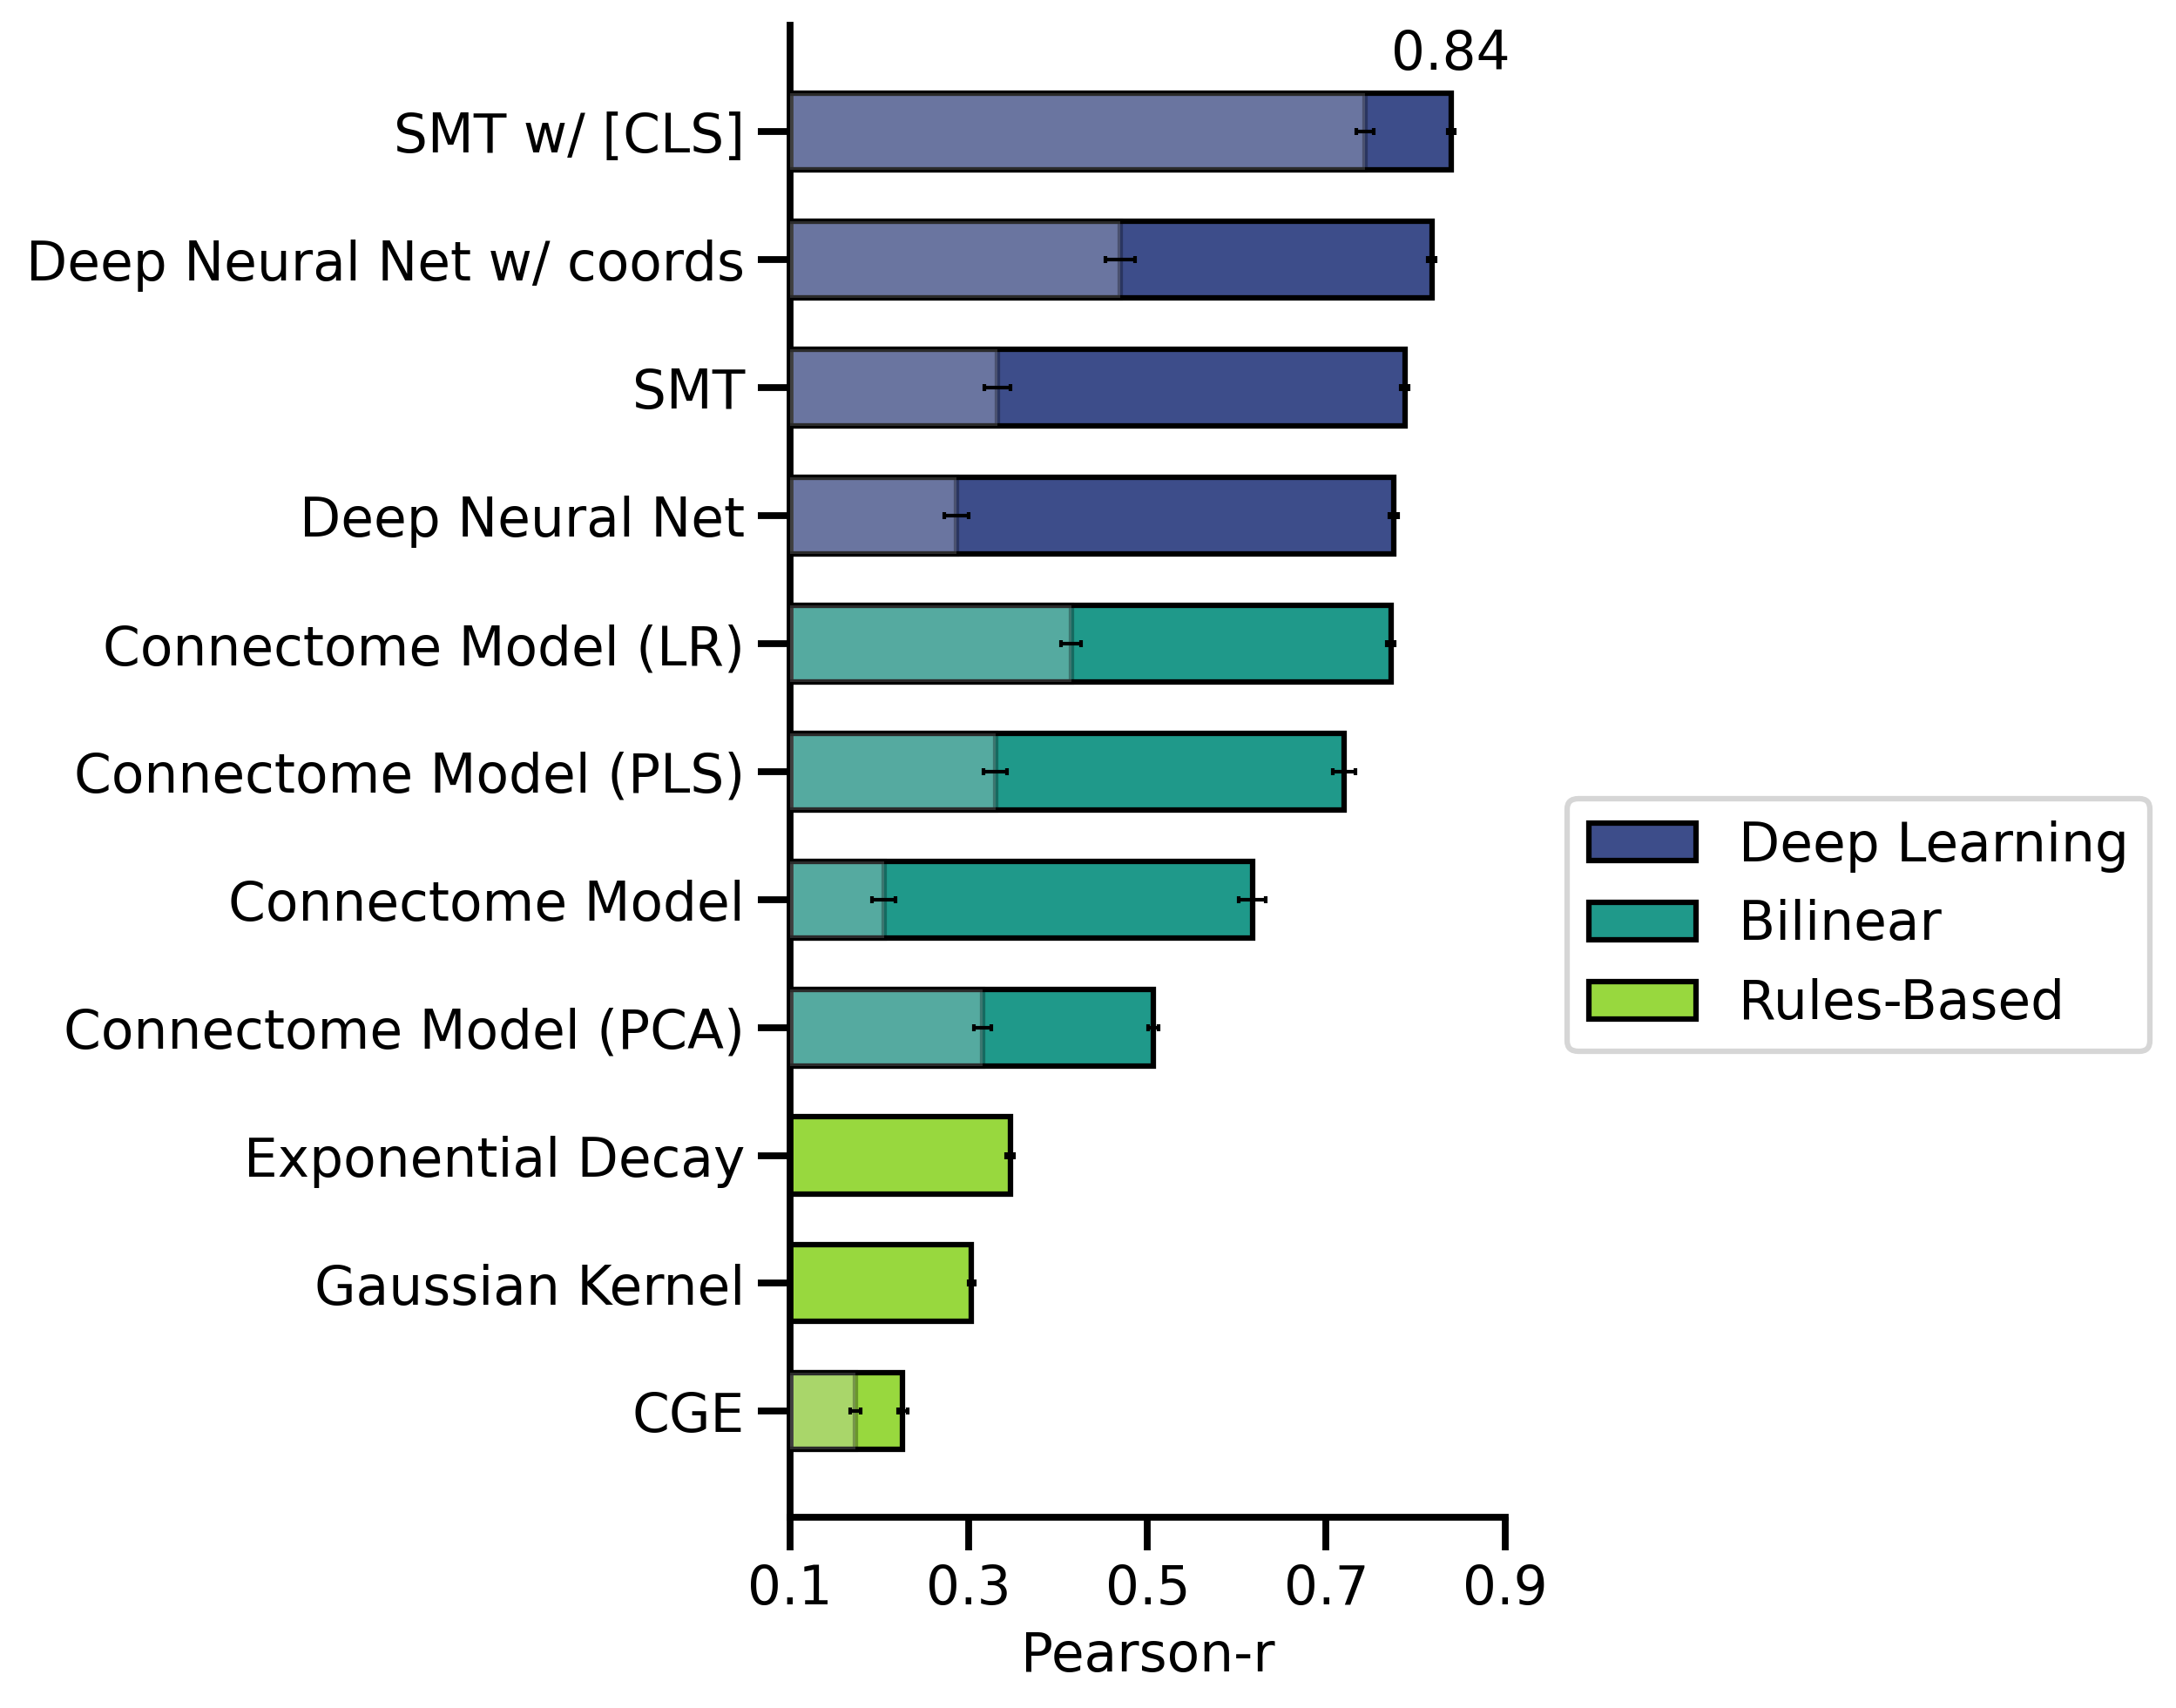

In [30]:
plot_true_vs_null_model_barchart_w_legend(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

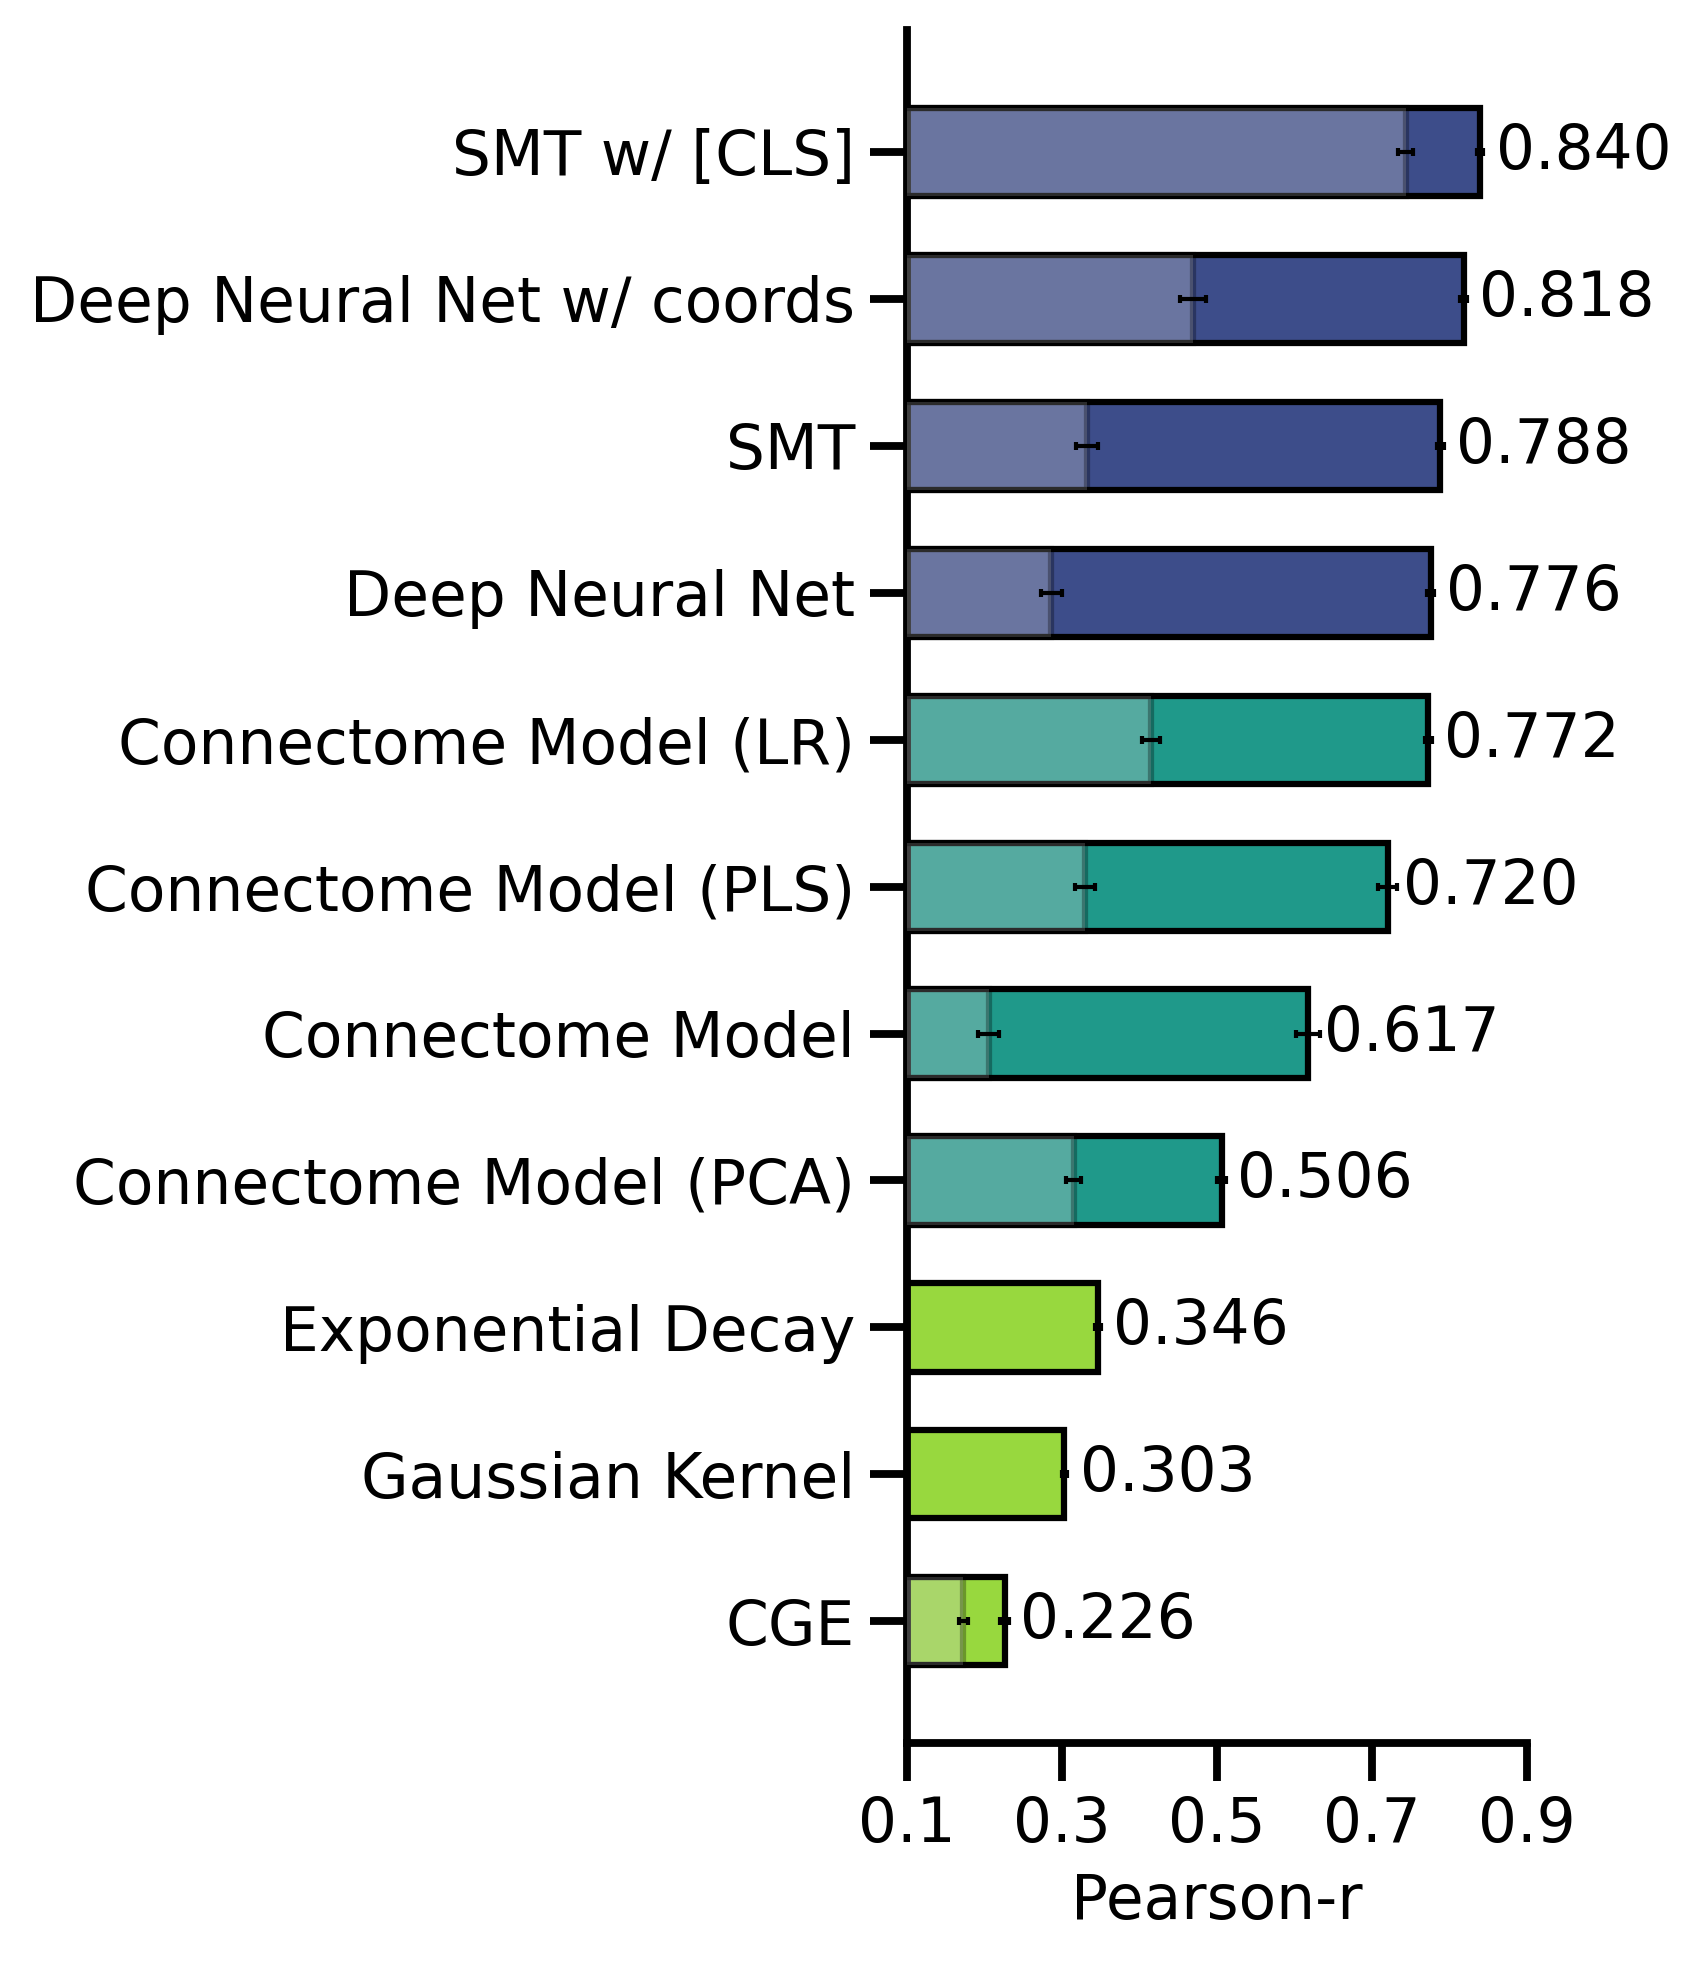

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [31]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

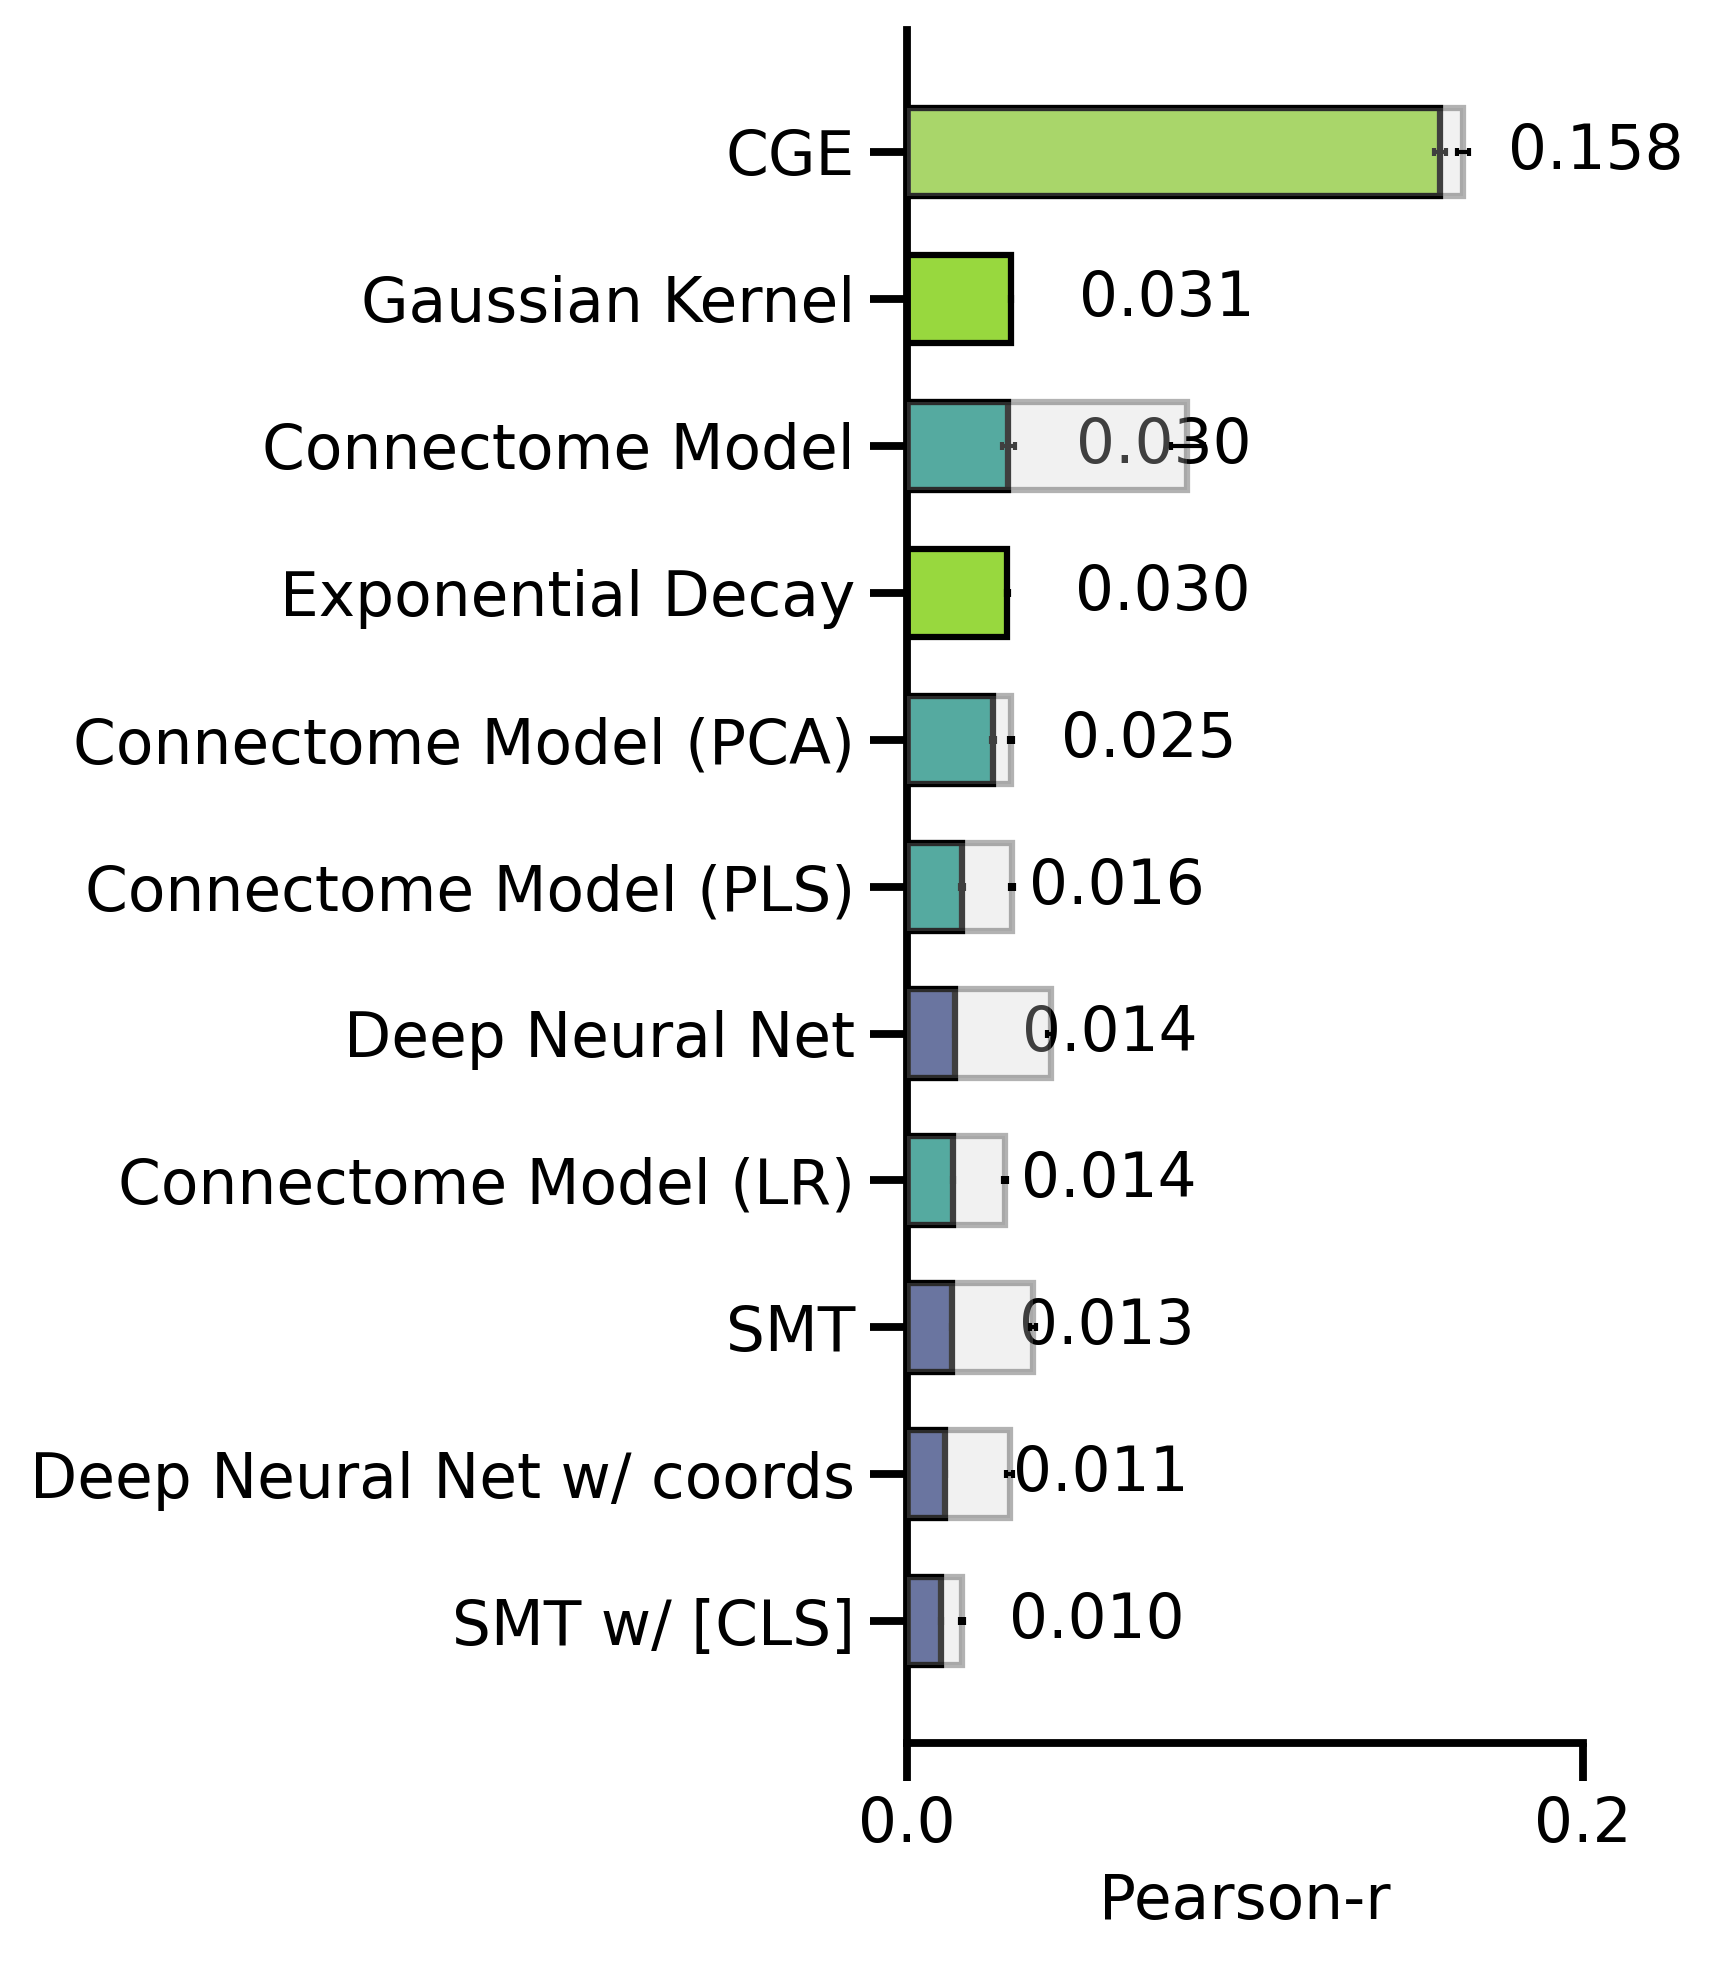

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [32]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_mse",
    xlim=(0.0, 0.05),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

Search and plot spatial

In [26]:
# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

model_groups = {
    'rules based': ['cge', 'gaussian_kernel', 'exponential_decay'],
    'bilinear': ['bilinear_CM', 'bilinear_CM_PCA', 'pls_bilineardecoder', 'bilinear_lowrank'],
    'deep learning': ['dynamic_mlp', 'dynamic_mlp_coords', 'shared_transformer', 'shared_transformer_cls']
}

cv_type = 'spatial'
null_model = 'none'
days = 60

# Store summary DataFrames
summary_dict_spatial = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_spatial)


cv_type = 'spatial'
null_model = 'spin'
days = 60

# Store summary DataFrames
summary_dict_spatial_spin = {}
process_model_feature_combinations(cv_type, null_model, days, models, model_feature_types, summary_dict_spatial_spin)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=spatial, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=spatial, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

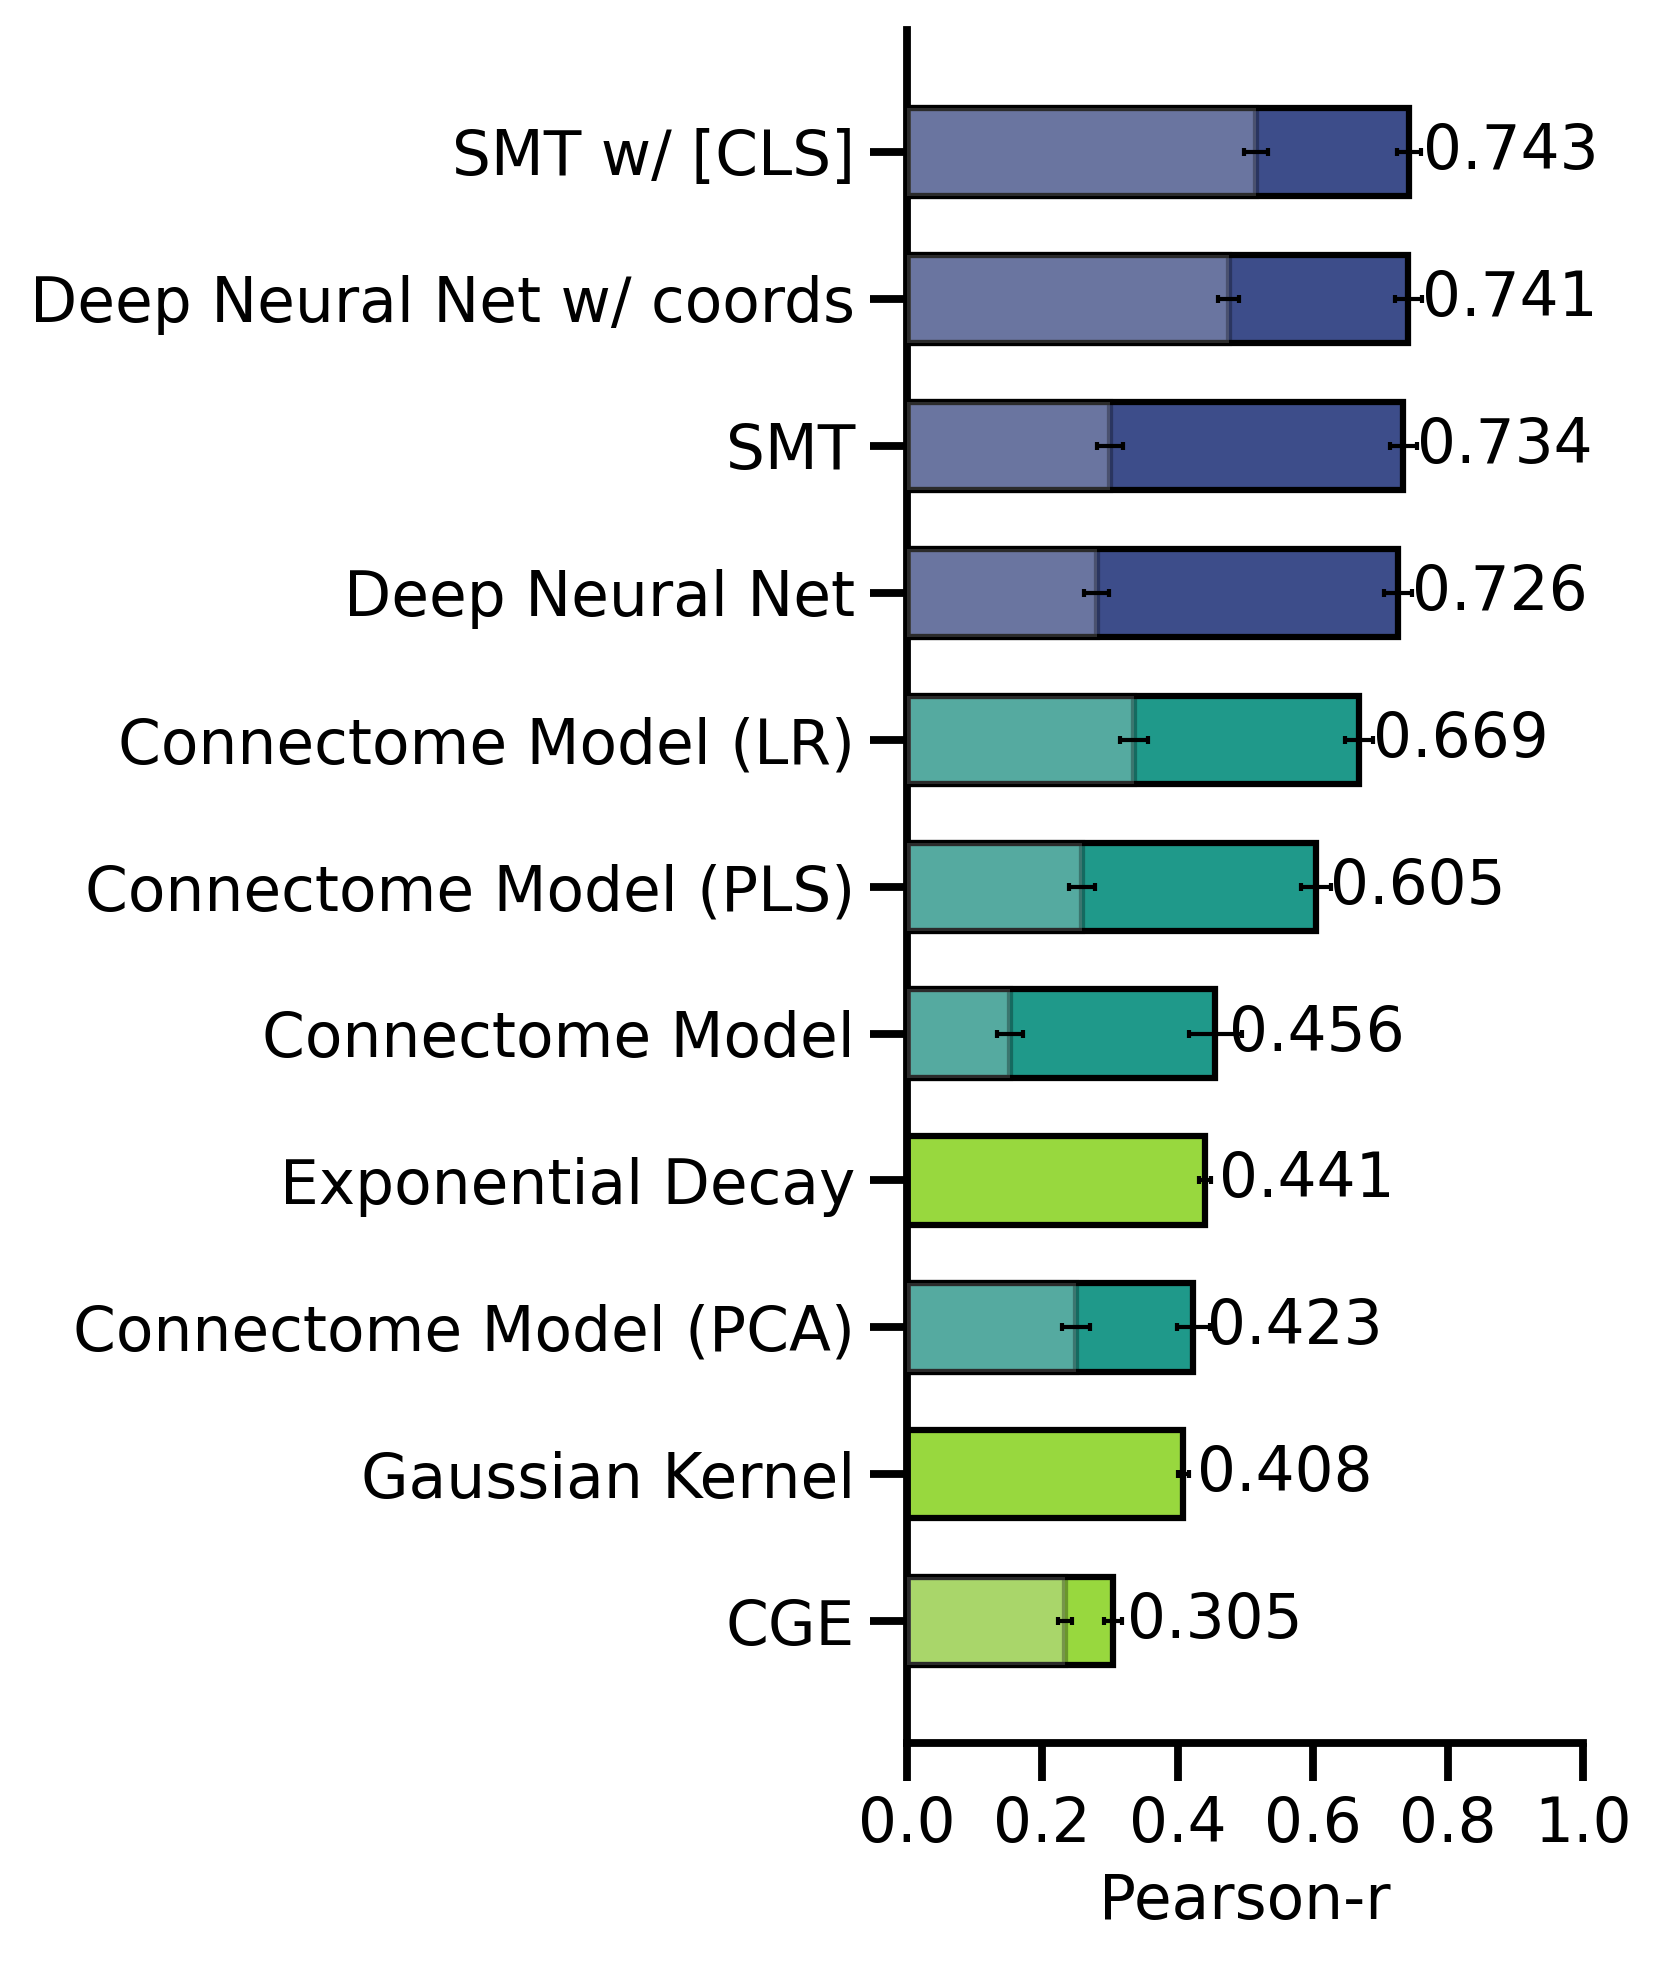

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [27]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

In [18]:
summary_df, history_df = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', days=7, use_weighted=False, exclude='HCP', return_history=True)

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome


In [23]:
history_df['final_test_pearson_r'].tolist()

[0.8733376816100826,
 0.8306109776002961,
 0.8255044019887703,
 0.822099896752721,
 0.8191077930550925,
 0.8129666704100795,
 0.8065335462102095,
 0.7789616159450625,
 0.7763640858857722,
 0.7720332602542282,
 0.7634571746456162,
 0.7510201513273655,
 0.7494036317537862,
 0.748534686102174,
 0.7463557027115482,
 0.7328019299442406,
 0.7319306457843202,
 0.7292116915785155,
 0.7291176340566929,
 0.7274978728862591,
 0.7196273013089032,
 0.7125283543165498,
 0.6991279699320272,
 0.6867935567197117,
 0.6835127400352774,
 0.6752442417393413,
 0.6443053676509708,
 0.6436206830653575,
 0.637435853882156,
 0.6346105779753041,
 0.6154383205925941,
 0.5561236126855821,
 0.5526313566286989,
 0.5495652432289729,
 0.5427047283939351,
 0.5392190278486901,
 0.4914150596472009,
 0.4274575812669746,
 0.414934581110622,
 0.39987985221514705]

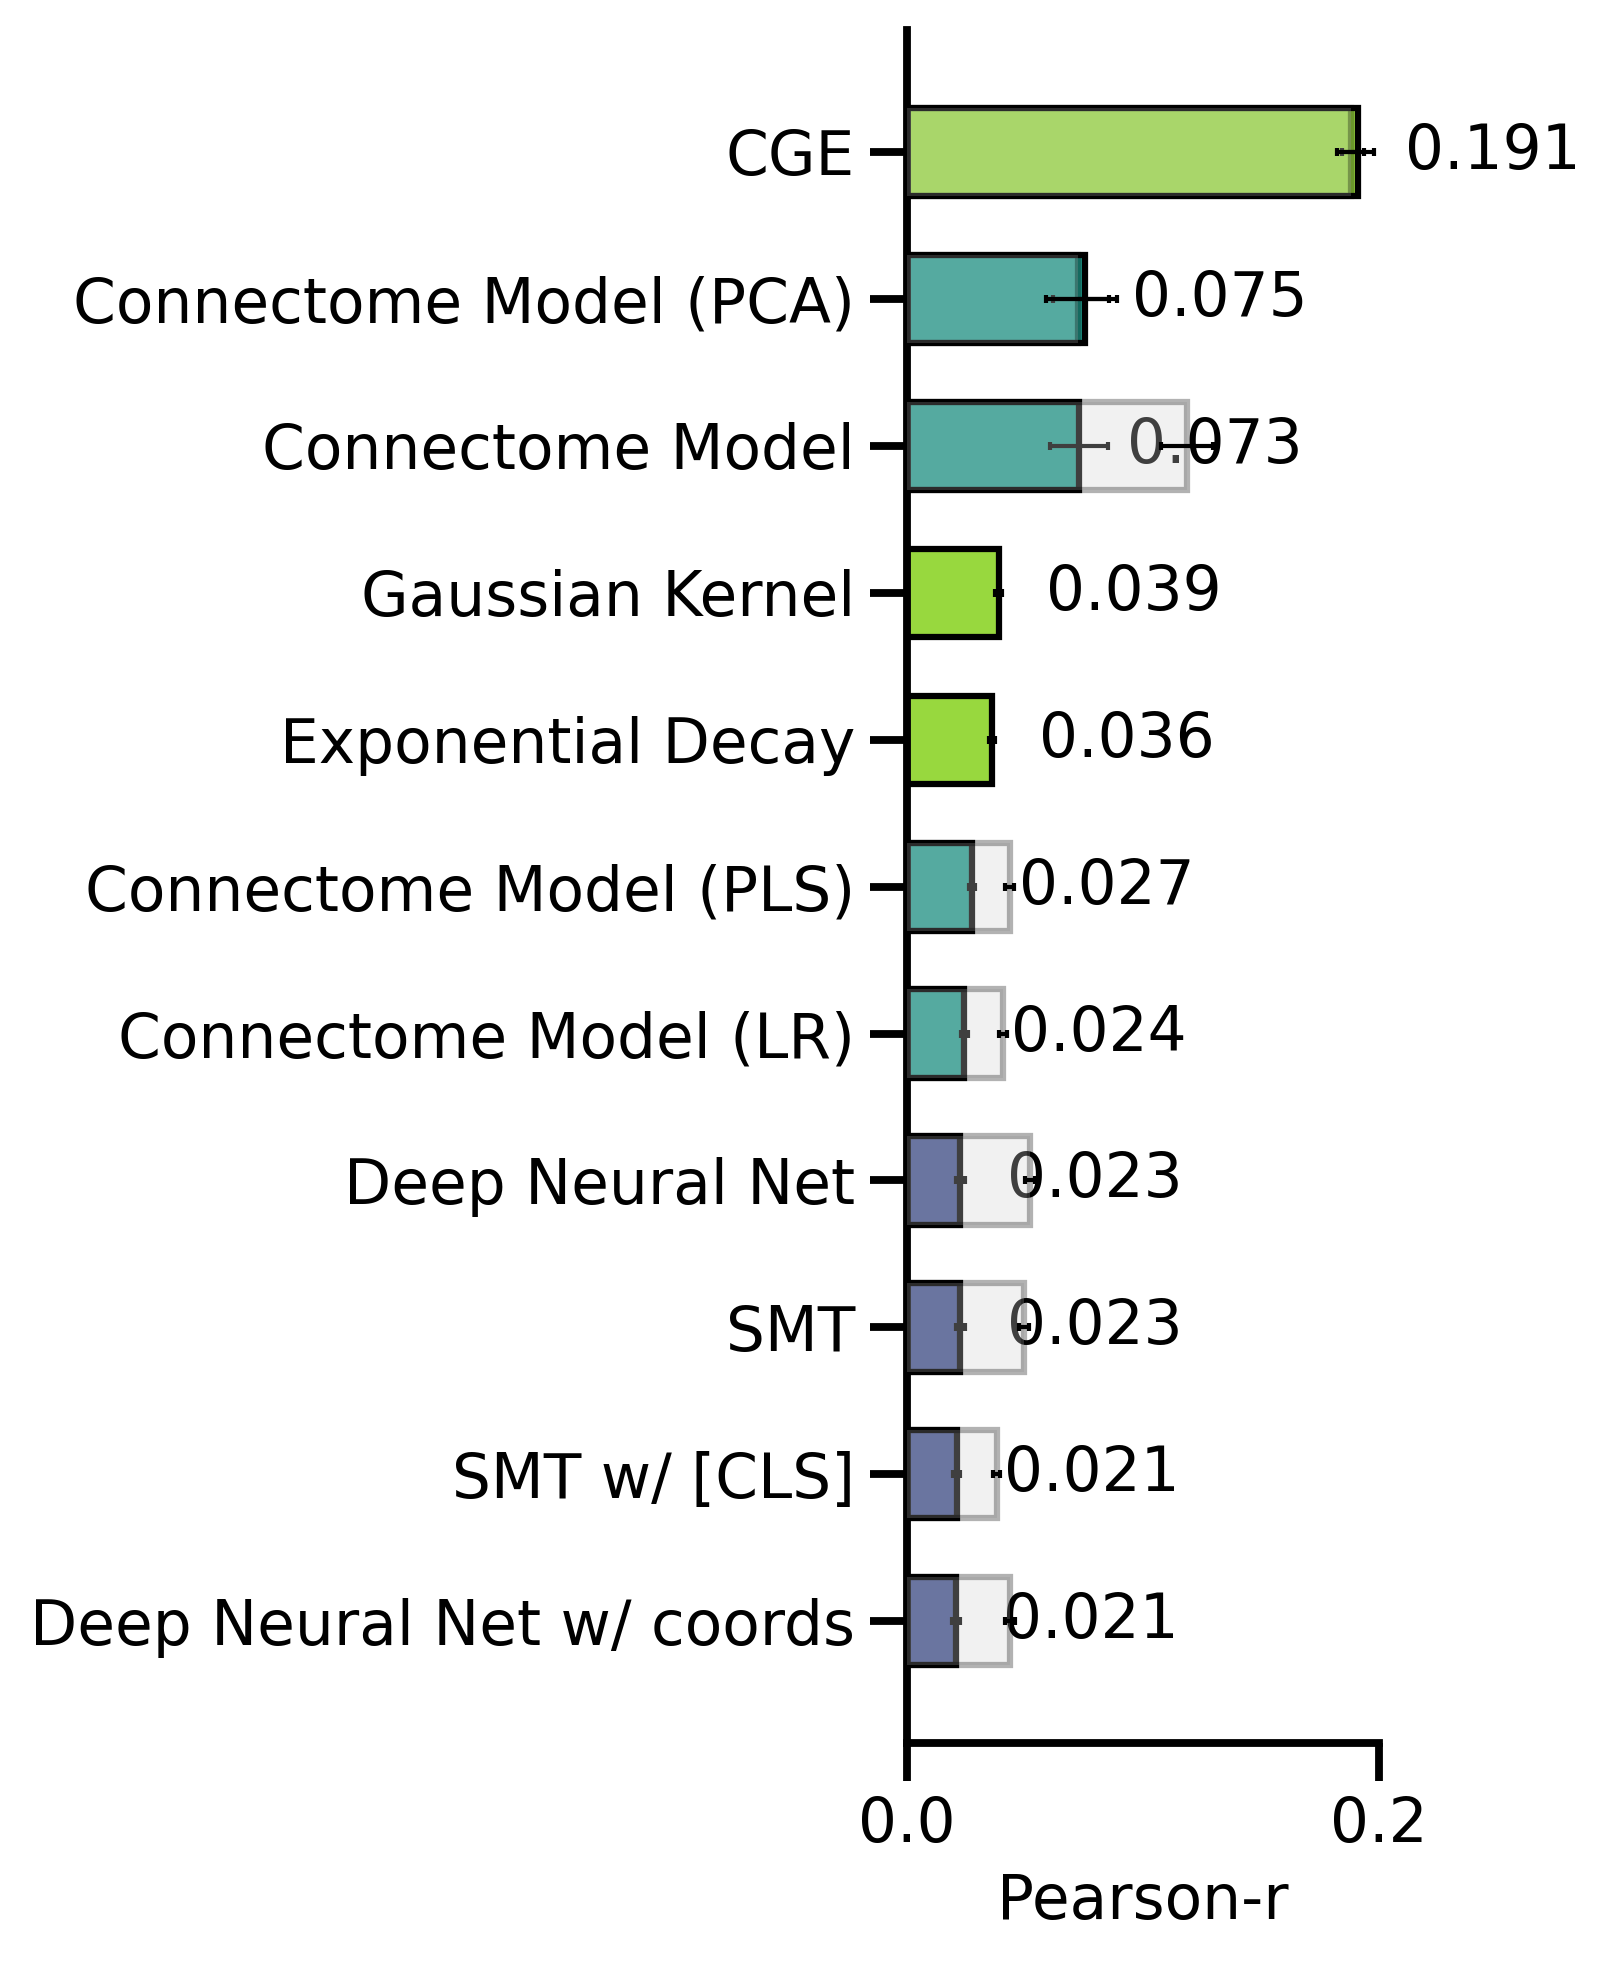

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [28]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_mse",
    xlim=(0.0, .05),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)